# 4. Data analysis – tree coverage and population distribution

Now that we have computed all the information we need on Earth Engine, we can start further analyzing it locally.

Apart from the total tree covered area in each city, one important aspect is how many people live in areas with good and bad tree cover. Some cities have significant green areas, but they are in unpopulated places – either richer, low-density neighborhoods or forested swathes of land on the periphery.

Instead of focusing on this, we want to know how lush is the tree coverage in areas with high population density. To do so, we will discover how many people are living within hexagons of different tree coverage levels.

If 20% of a cities population lives in areas with 10% tree coverage, we can say that more people experience a green lifestytle than a city where 5% of the population lives in the same conditions.

We can also visualize this distribution with "population histograms", which will give a better idea of how many people are living on each level of tree coverage.

In [1]:
# Importing packages
import datawrapper
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [2]:
# Settings
pd.set_option('chained_assignment', None) # default 'warn'

## 4.1 Loading relevant data

In [3]:
# Original city information
cities = gpd.read_file("../input/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")

# Keeps only identifier columns nad geometry
cities = cities[["ID_HDC_G0", "CTR_MN_NM", "UC_NM_MN", "CTR_MN_ISO", "UC_NM_LST", # Names and identifiers
                 "INCM_CMI", "DEV_CMI", # Income and development markers
                 "E_BM_NM_LST", "E_KG_NM_LST",   # Biomes and climates
                 'geometry'
                ]]

In [4]:
# Extra information on continent, region and subregion
info = pd.read_csv("../input/country_classifications/country-and-continent-codes-list.csv", sep=';')

# Keeps only useful identifier columns
info = info[['ISO-alpha3 code', 'continent', 'region', 'subregion']]

In [5]:
# Original hexbin shapefile
hex_shp = gpd.read_file("../output/city_hexagons/city_hexagons.shp")

In [6]:
# Hexbins with the computed data
hex_data = pd.read_csv("../output/earth_engine_exports/TreeCoverAnalysis-Hexagons-02-09-24-11_15.csv")

In [7]:
# Joins shapes, data and city information in a sin
hexbins = hex_data.merge(hex_shp, on=['city_id', 'hexagon_n'])\
        .merge(cities.drop(columns='geometry'), left_on='city_id', right_on='ID_HDC_G0')\
        .merge(info, left_on='CTR_MN_ISO', right_on='ISO-alpha3 code')

In [8]:
# Makes it, again, into a geodataframe
hexbins = gpd.GeoDataFrame(hexbins)

In [9]:
hexbins.head()

,city_id,hexagon_n,lon,lat,tree_area,ft_area,tree_pct,pop_ft,area,geometry,...,CTR_MN_ISO,UC_NM_LST,INCM_CMI,DEV_CMI,E_BM_NM_LST,E_KG_NM_LST,ISO-alpha3 code,continent,region,subregion
0,1452.0,0,-17.501080,14.754880,775.859839,723483.501045,0.001072,2752.569644,0.723621,"POLYGON ((-17.50113 14.75950, -17.49674 14.757...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
1,1452.0,1,-17.422321,14.744907,3424.605559,722867.374470,0.004738,13226.590721,0.723114,"POLYGON ((-17.42237 14.74952, -17.41798 14.747...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
2,1452.0,2,-17.465827,14.728914,12.499531,723063.880962,0.000017,15852.254603,0.723099,"POLYGON ((-17.46588 14.73353, -17.46149 14.731...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
3,1452.0,3,-17.339451,14.755890,144167.964578,722790.313681,0.199460,2505.278298,0.722871,"POLYGON ((-17.33950 14.76050, -17.33511 14.758...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
4,1452.0,4,-17.422019,14.717225,0.000000,722465.937096,0.000000,0.000000,0.722732,"POLYGON ((-17.42207 14.72184, -17.41768 14.719...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa


## 4.2 Population distribution in different tree cover areas

In [10]:
# Puts each one of the hexbins in a 'tree coverage bucket': for example,
# hexagons with a 29% tree coverage will fall in the bucket (28% – 30%),
# if the step is set to 0.02
step = .02
start, end = 0, 1 + step
bin_edges = np.arange(start, end, step)
hexbins['tr_pct_bin'] = pd.cut(hexbins['tree_pct'], 
                                      bins=bin_edges, include_lowest=True, right=False)

In [11]:
# A function to compute the share of population living in each one of the tree coverage levels computed above
def compute_pop_distribution(hexbins):
    '''
    For each city, computes how many people are living in
    hexagons with different levels of tree coverage.

    Parameters:
    hexbins (geopandas.GeoDataFrame): the geodataframe containing all the hexagons.

    Returns:
    pd.DataFrame: a DataFrame showing the percentage and total people living at each tree coverage level,
    for each city.
    '''
    
    # Groupby on city identifiers and bin size, then sum the total population.
    # This will give us the number of people living in each level of tree coverage.
    group_columns = ['city_id', 'tr_pct_bin']
    distributions = hexbins.groupby(group_columns)['pop_ft'].sum().reset_index()
    
    # Now we take the total population of the hexagons in city, transformed
    # in a way that it can directly divide the population of the hexagon.
    city_populations = distributions.groupby('city_id').pop_ft.transform('sum')
    
    # Computes the percentage for the distributions by dividing the population
    # on each hexagon by the total population computed above.
    distributions['pop_ft_pct'] = distributions.pop_ft / city_populations
    
    # Keeps the recquired information columns,
    # drop duplicates and merges them back into the dataframe.
    info = hexbins.drop_duplicates(subset=['city_id', 'tr_pct_bin'])
    info = info[['city_id', 'tr_pct_bin', 'UC_NM_MN', 'CTR_MN_NM', 'CTR_MN_ISO', 'continent', 'INCM_CMI']]
    distributions = distributions.merge(info, on=['city_id', 'tr_pct_bin'])
    
    return distributions


In [12]:
# Now, for each city, we have the distribution of the population living in each tree coverage area.
# Let's save that so we can access later.
pop_distribution = compute_pop_distribution(hexbins)
pop_distribution.to_csv("../output/population-by-tree-coverage-bin.csv", index=False)
pop_distribution.head()

,city_id,tr_pct_bin,pop_ft,pop_ft_pct,UC_NM_MN,CTR_MN_NM,CTR_MN_ISO,continent,INCM_CMI
0,10.0,"[0.0, 0.02)",535863.397407,0.113691,San Jose,United States,USA,Americas,HIC
1,10.0,"[0.02, 0.04)",696202.730230,0.147709,San Jose,United States,USA,Americas,HIC
2,10.0,"[0.04, 0.06)",757926.919928,0.160805,San Jose,United States,USA,Americas,HIC
3,10.0,"[0.06, 0.08)",617455.151767,0.131002,San Jose,United States,USA,Americas,HIC
4,10.0,"[0.08, 0.1)",467465.030952,0.099179,San Jose,United States,USA,Americas,HIC


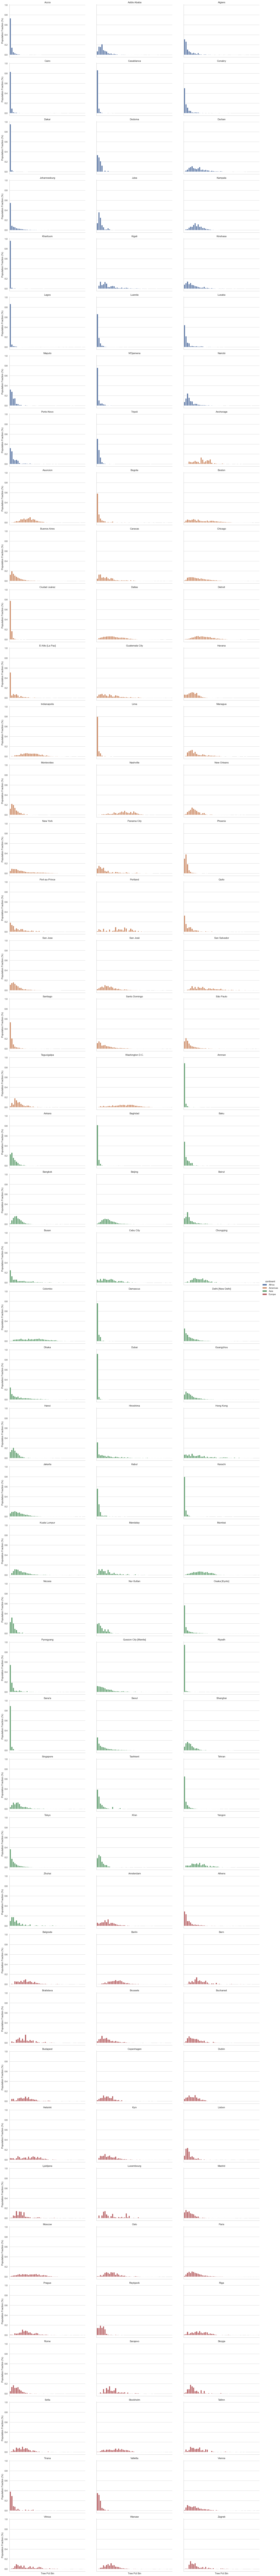

<Figure size 640x480 with 0 Axes>

In [13]:
# Let's quickly visualize that, making histogram-like shapes that show the 
# share of the population living in each bucket for each city.
# The code in this cell was written with the help of Chat GPT 4o.

# Set the seaborn style
sns.set(style="whitegrid")

# Create the small multiples (one for each city)
g = sns.FacetGrid(pop_distribution.sort_values(by=['continent', 'UC_NM_MN']),
                  col="UC_NM_MN", hue="continent", col_wrap=3, height=4, aspect=1.5)

# Map the barplot to the grid
g.map(sns.barplot, "tr_pct_bin", "pop_ft_pct", order=sorted(pop_distribution['tr_pct_bin'].unique()))

# Add a legend and adjust the layout
g.add_legend()
g.set_axis_labels("Tree Pct Bin", "Population Fraction (%)")
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
# Show the plot
plt.show()

plt.savefig("../readme-images/histograms.png")

## 4.3 Visualizing hexagon maps of key cities

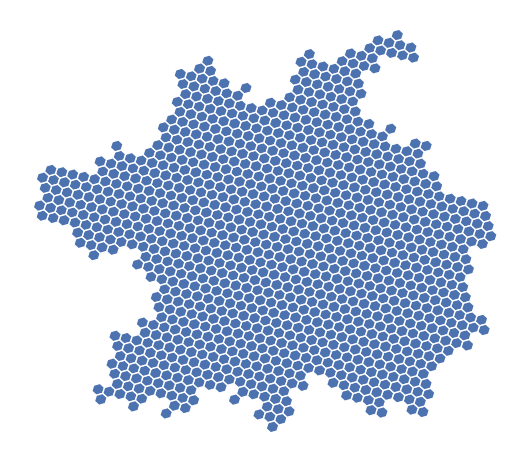

In [14]:
# We can also quickly visuaslize any given city as an hexagon map.
# For example, this is all the hexagons that make up Berlin:
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot()
ax.axis('off')
plt.tight_layout()

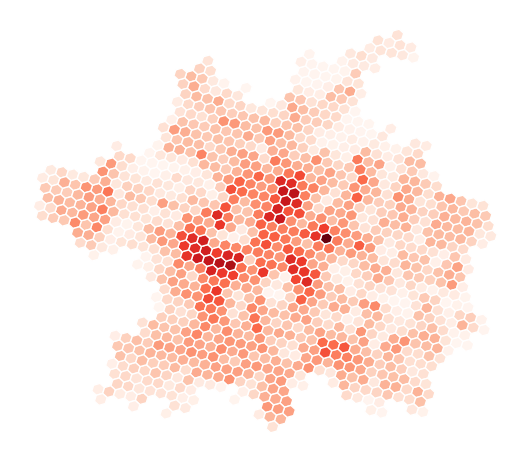

In [15]:
# We can show the population density
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='pop_ft', cmap='Reds')
ax.axis('off')
plt.tight_layout()

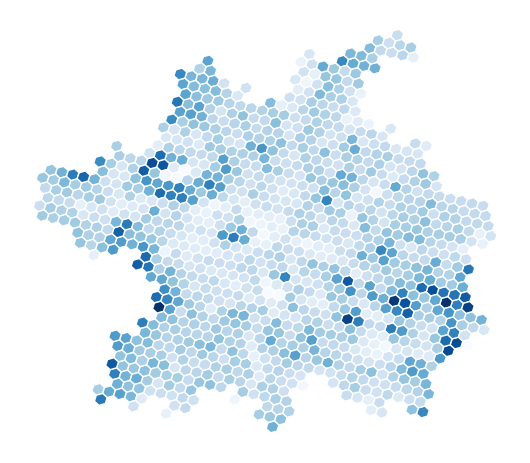

In [16]:
# And the tree density
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='tree_pct', cmap='Blues')
ax.axis('off')
plt.tight_layout()

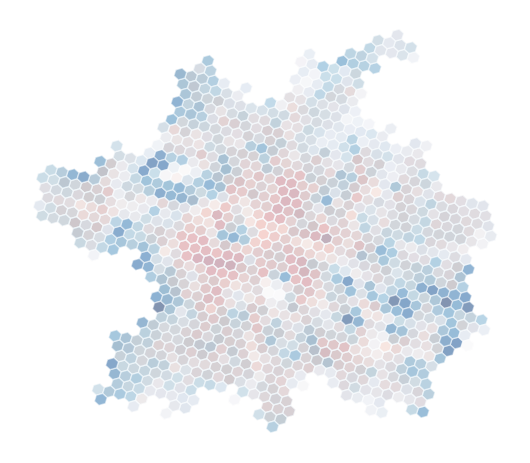

In [17]:
# And we can lay one over the other, highlighting places
# that have at the same time lots of trees and lots of people.
# Those are the dark gray areas.
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='pop_ft', cmap='Reds', alpha=.5)
hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='tree_pct', cmap='Blues', alpha=.5, ax=ax)
ax.axis('off')
plt.tight_layout()


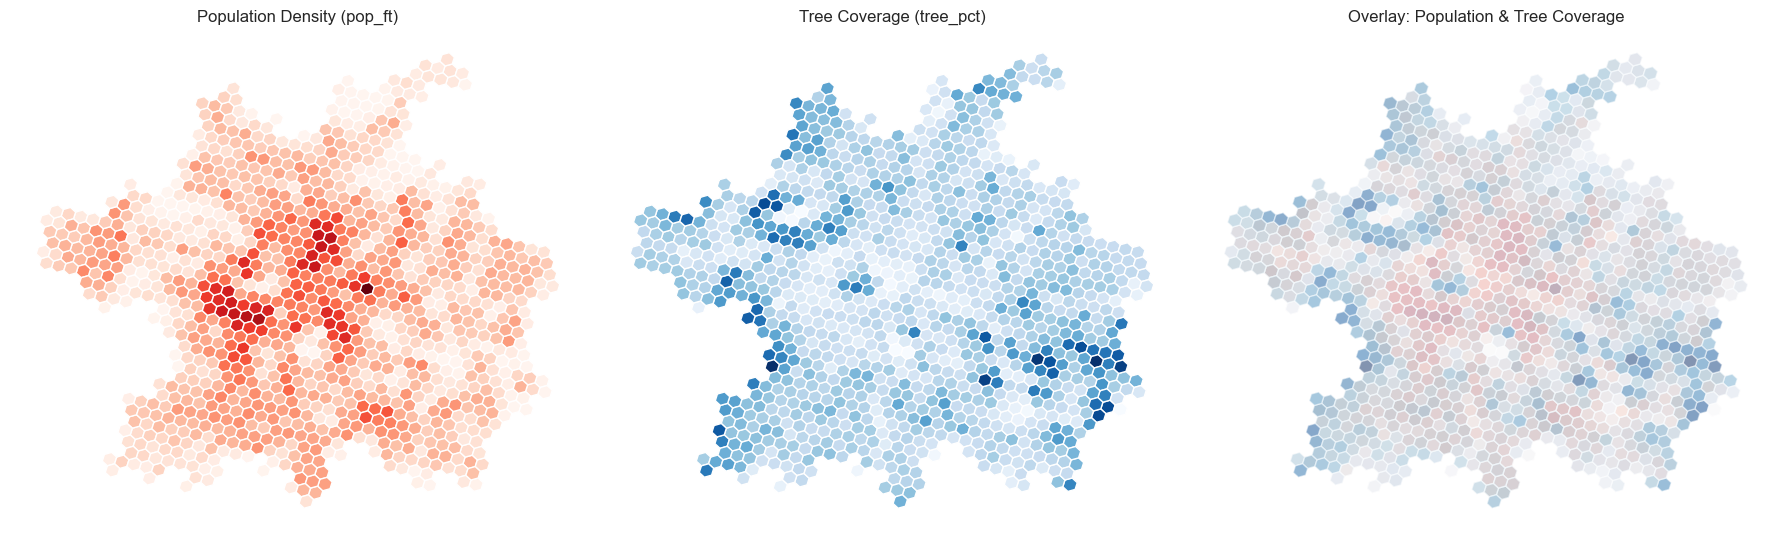

In [18]:
# Let's plot them side by side
berlin_data = hexbins[hexbins.UC_NM_MN == 'Berlin']

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: pop_ft
berlin_data.plot(column='pop_ft', cmap='Reds', alpha=1, ax=axs[0])
axs[0].set_title('Population Density (pop_ft)')
axs[0].axis('off')  # Hide the axes

# Second subplot: tree_pct
berlin_data.plot(column='tree_pct', cmap='Blues', alpha=1, ax=axs[1])
axs[1].set_title('Tree Coverage (tree_pct)')
axs[1].axis('off')  # Hide the axes

# Third subplot: overlay of pop_ft and tree_pct
ax = berlin_data.plot(column='pop_ft', cmap='Reds', alpha=0.5, ax=axs[2])
berlin_data.plot(column='tree_pct', cmap='Blues', alpha=0.5, ax=ax)
axs[2].set_title('Overlay: Population & Tree Coverage')
axs[2].axis('off')  # Hide the axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 4.4 Exporting data for visualizing on Datawrapper

### Small multiple histograms

In [19]:
# Parses the data in a format that can be used at Datawrapper
# for population histograms of selected cities

# Copies the data seen above
dw_histograms = pop_distribution.copy()

# Extracts a threshold to use in the x axis
dw_histograms['max_threshold'] = dw_histograms.tr_pct_bin.map(lambda x: int(float(x.right) * 100))

# Selects the desired cities – all in DW Prio countries
# plus other countries of interest.
iso3_codes = ["CHN", "IND", "IDN", "IRN", "PAK", "AFG", "BGD", "PHL", "THA", "VNM", "MYS", "LKA", "TWN", 
              "JPN", "MMR", "TWN"]
dw_histograms = dw_histograms[dw_histograms.CTR_MN_ISO.isin(iso3_codes)]

# Creates a city + country column
dw_histograms['column_name'] = dw_histograms['UC_NM_MN'] + ', ' + dw_histograms['CTR_MN_NM']

# Keep only the informative columns
dw_histograms = dw_histograms[['max_threshold', 'column_name', 'pop_ft_pct']]

# Pivots so we have the cities as columns
dw_histograms = dw_histograms.pivot(index='max_threshold', columns='column_name', values='pop_ft_pct').reset_index()

# Saves to CSV
dw_histograms.to_csv("../output/datawrapper_files/population-histograms.csv", index=False)

### Bubble map

In [20]:
# Data for a bubble map showing the most populous tree coverage level of each city.
dw_map = pop_distribution.copy()

# Keeps only the most populous bin
dw_map = dw_map.loc[dw_map.groupby('city_id').pop_ft.idxmax()]

# Creates upper and lower bounds for each city
dw_map['lower'] = dw_map.tr_pct_bin.map(lambda x: int(float(x.left * 100))).astype(int) # we want in int, not category
dw_map['upper'] = dw_map.tr_pct_bin.map(lambda x: int(float(x.right * 100))).astype(int)

# Creates a single name for geolocation
dw_map['city_name'] = dw_map.UC_NM_MN + ", " + dw_map.CTR_MN_NM

# Adds extra information on biome and climate
dw_map = dw_map.merge(cities[['ID_HDC_G0', 'E_BM_NM_LST', 'E_KG_NM_LST', 'geometry']], left_on='city_id', right_on='ID_HDC_G0')

# Keeps only Asian cities
# dw_map = dw_map[dw_map.continent=='Asia']

# Keep only the desired columns
dw_map = dw_map[['city_id', 'city_name', 'UC_NM_MN', 'CTR_MN_NM', 'pop_ft_pct', 'E_BM_NM_LST', 'E_KG_NM_LST', 'upper', 'lower', 'continent', 'geometry']]

# Gets the share of population per bin per city by pivotting, fillings any nans
# and melting back
shares = pop_distribution.pivot(columns=['tr_pct_bin'], index='city_id', values='pop_ft_pct')\
    .fillna(0)\
    .reset_index()\
    .melt(id_vars='city_id', value_name='pop_ft_pct')\
    .sort_values(by=['city_id', 'tr_pct_bin'])

# Creates upper and lower bounds for each city
shares['lower'] = shares.tr_pct_bin.map(lambda x: int(float(x.left * 100))).astype(int) # we want in int, not category
shares['upper'] = shares.tr_pct_bin.map(lambda x: int(float(x.right * 100))).astype(int)

# Sets up a tree coverage breakpoint
n = 20

# For each city, compute the total population living over the tree coverage breakpoint
shares[f'over_{n}'] = shares.upper >= n

# Gets the share of population over and under the desired threshold
shares = shares.groupby(['city_id', f'over_{n}']).pop_ft_pct.sum().reset_index()

# Keeps only the population over it
shares = shares[shares[f'over_{n}']]\
    .reset_index(drop=True)\
    .drop(columns=[f'over_{n}'])\
    .rename(columns={'pop_ft_pct': f'pop_over_{n}'})


# Merges back with the previous map information
dw_map = dw_map.merge(shares, on='city_id')

# Renames so it makes more sense
dw_map = dw_map.rename(columns={
    "pop_ft_pct": "pop_in_modal_bin",
    "upper": "modal_bin_upper",
    "lower": "modal_bin_lower"
})

# Puts in percentage points
dw_map['pop_over_20'] = dw_map.pop_over_20 * 100
dw_map['pop_in_modal_bin'] = dw_map.pop_in_modal_bin * 100

# Gets lat and lon
dw_map['lon'] = gpd.GeoSeries(dw_map.geometry).centroid.get_coordinates().x
dw_map['lat'] = gpd.GeoSeries(dw_map.geometry).centroid.get_coordinates().y


# Saves
dw_map[dw_map.continent=='Asia'].to_csv("../output/datawrapper_files/asia-map.csv", index=False)

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_5259/2996288896.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dw_map['lon'] = gpd.GeoSeries(dw_map.geometry).centroid.get_coordinates().x
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_5259/2996288896.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dw_map['lat'] = gpd.GeoSeries(dw_map.geometry).centroid.get_coordinates().y


#### Datawrapper Swarmplot

In [21]:
# Starts from the map
dw_swarm = dw_map.copy()

# Orders by continent, aplhabetically
dw_swarm = dw_swarm.sort_values(by='continent')

# Attributes an numeric value to each column
dw_swarm['order'] = pd.factorize(dw_swarm['continent'])[0] * 2

# Creates a rough grouping of rounded pop_counts
dw_swarm['rounded_pop_over_20'] = dw_swarm.pop_over_20.round()

# Made with ChatGPT
# Function to add random jitter
def jitter(group, jitter_strength=.5, seed=20):
    
    n = len(group)
    
    # Generate random shifts between -jitter_strength and +jitter_strength,
    # ensuring no point stays exactly at the order position (no shift = 0).
    jitter = []
    for i in range(n):
        shift = 0
        while shift == 0:  # Keep generating until the shift is non-zero
            shift = random.randint(-int(jitter_strength * 10), int(jitter_strength * 10)) / 10.0
        jitter.append(shift)
        
    # Apply jitter to the order value
    group['position'] = group['order'] + jitter
    
    return group

dw_swarm = dw_swarm.groupby(['order', 'rounded_pop_over_20'], group_keys=False).apply(jitter)

# Saves
dw_swarm.to_csv("../output/datawrapper_files/swarm-plot-continentes.csv", index=False)

In [22]:
dw_swarm

,city_id,city_name,UC_NM_MN,CTR_MN_NM,pop_in_modal_bin,E_BM_NM_LST,E_KG_NM_LST,modal_bin_upper,modal_bin_lower,continent,geometry,pop_over_20,lon,lat,order,rounded_pop_over_20,position
65,3209.0,"Kinshasa, Democratic Republic of the Congo",Kinshasa,Democratic Republic of the Congo,14.192966,"Tropical and subtropical grasslands, savannas,...",Tropical savannah with dry winter,6,4,Africa,"MULTIPOLYGON (((15.29252 -4.29610, 15.32250 -4...",22.090406,15.319213,-4.396635,0,22.0,0.4
33,1452.0,"Dakar, Senegal",Dakar,Senegal,95.497962,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",2,0,Africa,"MULTIPOLYGON (((-17.32044 14.82350, -17.28987 ...",0.466685,-17.379472,14.742928,0,0.0,-0.1
34,1502.0,"Conakry, Guinea",Conakry,Guinea,50.360746,Tropical and Subtropical Moist Broadleaf Forests,Tropical monsoon,2,0,Africa,"MULTIPOLYGON (((-13.49298 9.83697, -13.48291 9...",3.775396,-13.546166,9.668177,0,4.0,-0.1
37,1575.0,"Casablanca, Morocco",Casablanca,Morocco,86.389914,"Mediterranean Forests, Woodlands, and Scrub","Mild temperate with dry summer, and Hot summer",2,0,Africa,"MULTIPOLYGON (((-7.34939 33.73667, -7.32701 33...",0.110980,-7.548503,33.586149,0,0.0,0.4
40,1910.0,"Accra, Ghana",Accra,Ghana,73.381672,"Tropical and subtropical grasslands, savannas,...",Tropical savannah with dry winter,2,0,Africa,"MULTIPOLYGON (((-0.33030 5.76215, -0.31028 5.7...",0.424687,-0.215574,5.621094,0,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,3332.0,"Skopje, Macedonia",Skopje,Macedonia,17.947444,Temperate Broadleaf and Mixed Forests,"Mild temperate, fully humid, and Hot summer",10,8,Europe,"MULTIPOLYGON (((21.44708 42.06606, 21.45909 42...",22.516163,21.424304,42.006994,6,23.0,5.6
71,3274.0,"Tirana, Albania",Tirana,Albania,38.143076,"Mediterranean Forests, Woodlands, and Scrub","Mild temperate with dry summer, and Hot summer",2,0,Europe,"MULTIPOLYGON (((19.74653 41.40652, 19.75846 41...",7.250496,19.798348,41.344277,6,7.0,6.4
70,3270.0,"Belgrade, Serbia",Belgrade,Serbia,10.105707,Temperate Broadleaf and Mixed Forests,"Mild temperate, fully humid, and Hot summer",22,20,Europe,"MULTIPOLYGON (((20.44226 44.89638, 20.47936 44...",63.643506,20.456555,44.797635,6,64.0,5.8
67,3244.0,"Helsinki, Finland",Helsinki,Finland,7.175009,Boreal Forests/Taiga,"Snow, fully humid, and Warm summer",12,10,Europe,"MULTIPOLYGON (((24.96694 60.32760, 24.98246 60...",67.650632,24.936992,60.223652,6,68.0,6.2


<Axes: xlabel='position', ylabel='pop_over_20'>

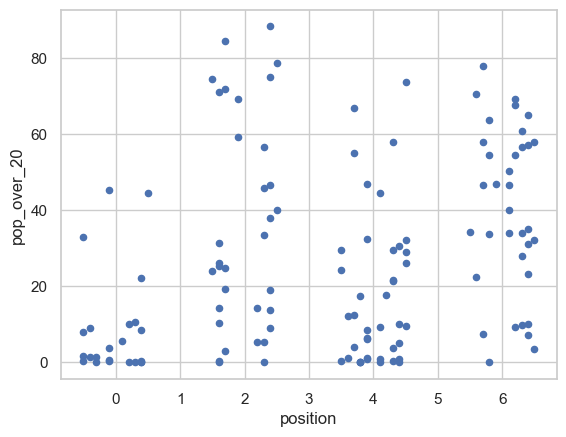

In [23]:
dw_swarm.plot(x='position', y='pop_over_20', kind='scatter')

#### Datawrapper custom hexagon map

In [24]:
# For each city id, a geojson
# For now, we are only making a map for Colombo (city id 8835)
for city_id in [8835]:
    
    # Select the columns
    subset = hexbins[hexbins.city_id == city_id]
        
    # Keeps one single id and geometry for the geojson
    geo = subset[['hexagon_n', 'geometry']]
    
    # Keep the important value information as a CSV file
    data = subset[['hexagon_n', 'tree_pct', 'pop_ft']]
    data['tree_pct'] = data.tree_pct * 100
    
    # Classifies the data in 3 buckets, using the percentiles as a cutting point
    n_classes = 3
    data['tree_class'] = pd.qcut(data['tree_pct'], n_classes, labels=False)
    data['pop_class'] = pd.qcut(data['pop_ft'], n_classes, labels=False)
    
    # Defines a class-to-label mapping
    class_labels = {
        0: 'low',
        1: 'medium',
        2: 'high',

    }
    
    # Makes sures that the number of labels matches the classes
    assert len(class_labels) == n_classes

    # Creates a readable text label
    data['tree_class_text'] = data.tree_class.map(class_labels)
    data['pop_class_text'] = data.pop_class.map(class_labels)
    
    # Create combined classification for tree and population
    data['combined_class'] = data.apply(
        lambda row: f"{class_labels[row['tree_class']]} trees, {class_labels[row['pop_class']]} pop", axis=1
    )


    # Output files
    fname = int(city_id)
    
    # Save geojson with geometry data
    geo.to_file(f"../output/datawrapper_files/geojson_maps/{fname}_{n_classes}classes.json")
    
    # Save CSV with data including hex color
    data[['hexagon_n', 'tree_pct', 'pop_ft', 'tree_class', 'tree_class_text', 'pop_class', 'pop_class_text',
          'combined_class']].to_csv(
        f"../output/datawrapper_files/map_data/{fname}_{n_classes}classes.csv", index=False
    )

#### Datawrapper climate histogram

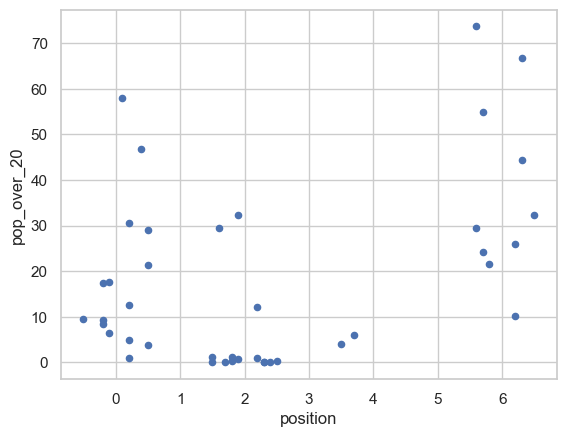

In [36]:
# Starts from the map
dw_climates = dw_map.copy()

# Keeps only asian cities
dw_climates = dw_climates[dw_climates.continent=='Asia']

dw_climates.E_KG_NM_LST.unique()

def classify_climate(climate):
    # Tropical climates
    if 'Tropical' in climate or 'rain forest' in climate or 'monsoon' in climate or 'savannah' in climate:
        return 'Tropical'
    
    # Dry climates (Desert and Steppe)
    elif 'Desert' in climate or 'Steppe' in climate:
        return 'Dry'
    
    # Temperate climates
    elif 'Mild temperate' in climate:
        return 'Temperate'
    
    # Continental climates (Snow-related)
    elif 'Snow' in climate:
        return 'Continental'
    
    # Polar climates (none explicitly mentioned in the array, but as a fallback)
    else:
        return 'Polar'
  
    
# Apply the function to the series
dw_climates['KG_broader'] = dw_climates['E_KG_NM_LST'].apply(classify_climate)

# Attributes an numeric value to each column
dw_climates['order'] = pd.factorize(dw_climates['KG_broader'])[0] * 2

# Creates a rough grouping of rounded pop_counts
dw_climates['rounded_pop_over_20'] = dw_climates.pop_over_20.round()

# Apply the force-clustered layout function
dw_climates = dw_climates.groupby(['order', 'rounded_pop_over_20'], group_keys=False).apply(jitter)

# Plot
dw_climates.plot(x='position', y='pop_over_20', kind='scatter')

# Saves
dw_climates.to_csv("../output/datawrapper_files/swarm-plot-climates.csv", index=False)

In [ ]:
# Starts from the map
dw_swarm = dw_map.copy()

# Orders by continent, aplhabetically
dw_swarm = dw_swarm.sort_values(by='continent')

# Attributes an numeric value to each column
dw_swarm['order'] = pd.factorize(dw_swarm['continent'])[0] * 2

# Creates a rough grouping of rounded pop_counts
dw_swarm['rounded_pop_over_20'] = dw_swarm.pop_over_20.round()

# Made with ChatGPT
# Function to add random jitter
def jitter(group, jitter_strength=.5, seed=20):
    
    n = len(group)
    
    # Generate random shifts between -jitter_strength and +jitter_strength,
    # ensuring no point stays exactly at the order position (no shift = 0).
    jitter = []
    for i in range(n):
        shift = 0
        while shift == 0:  # Keep generating until the shift is non-zero
            shift = random.randint(-int(jitter_strength * 10), int(jitter_strength * 10)) / 10.0
        jitter.append(shift)
        
    # Apply jitter to the order value
    group['position'] = group['order'] + jitter
    
    return group
# Apply the force-clustered layout function
dw_swarm = dw_swarm.groupby(['order', 'rounded_pop_over_20'], group_keys=False).apply(jitter)

# Saves
dw_swarm.to_csv("../output/datawrapper_files/swarm-plot-continentes.csv", index=False)

### One histogram per city (for tooltips)

In [25]:
# Copies the data seen above
all_histograms = pop_distribution.copy()

# We need one column for 'bin' and one column for the value.
# Also keep an city_id for merging later.

# Extracts a threshold to use in the x axis
all_histograms['max_threshold'] = all_histograms.tr_pct_bin.map(lambda x: int(float(x.right) * 100))

# Creates a city + country column
all_histograms['city_name'] = all_histograms['UC_NM_MN'] + ', ' + all_histograms['CTR_MN_NM']

# Pivots 
all_histograms = all_histograms.pivot(index='max_threshold', columns=['city_name'], values='pop_ft_pct').fillna(0)

# This is all the data that is needed. We can loop through the column names,
# create a chart using the API, store both column name and chart id on an array

SyntaxError: incomplete input (1595598204.py, line 21)